# Notebook of the project of Physics of Complex Systems #

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

Firstly, I try to reproduce the mean-field approach. The resulting system of ODEs is the following:
$$
    \frac{\partial x}{\partial t} = \alpha x - \gamma xy , \;\;\;
    \frac{\partial y}{\partial t} = \lambda + \nu xy - \sigma y
$$
where $x$ is the pathogen concentration and $y$ lymphocytes'. \
The parameters represent:
- $\alpha$ : birth rate of the pathogen; 
- $\gamma$ : destruction rate of the pathogen by the lymphocytes; 
- $\lambda$ : birth rate of the lymphocyte; 
- $\nu$ : duplication rate of the lymphocyte when encountering the pathogen; 
- $\sigma$ : death rate of the lymphocyte. 


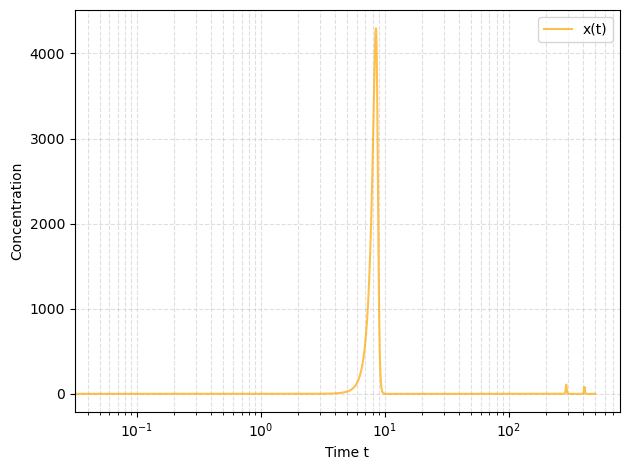

In [6]:
# set initial conditions
z0 = np.array([0.01,np.random.poisson(lam=1)])    # z=[x,y]

# parameters initialization (I use the parameters listed in the caption of Figure 3)
par = {
    'alpha': 1.6,
    'gamma': 0.01,   # questo sarebbe 0.01
    'lambda': 0.6,
    'nu': 0.001,
    'sigma': 0.01
}

def system(z:np.ndarray ,t:np.ndarray ,par:dict):
    
    x, y = z
    dxdt = par['alpha']*x - par['gamma']*x*y
    dydt = par['lambda'] + par['nu']*x*y - par['sigma']*y
    return [dxdt,dydt]

# set the time span 
#t_s = np.linspace(0,int(1e4),int(1e5))
t_s = np.linspace(0,500,10000)      # credo sia questo il time step che hanno usato

# Solve
X = odeint(system,z0,t_s,args=(par,))[:,0]
Y = odeint(system,z0,t_s,args=(par,))[:,1]

# Normalization

#plt.figure(figsize=(12,8))
plt.plot(t_s, X, c='orange', label='x(t)',alpha=0.7)
#plt.plot(t_s,Y,c='magenta',label='y(t)',alpha=0.7)
plt.xlabel('Time t')
plt.ylabel('Concentration')
plt.xscale('log')
plt.grid(True, which="both",alpha=0.4,linestyle='--')
plt.legend()
plt.tight_layout()
plt.show()


Ora c'è da fare il lattice -> fai una matrice 